<a href="https://colab.research.google.com/github/irahanjose/Aprendizaje-de-M-quina-con-Python/blob/main/underfitting_overfitting_diseno_red_neuronal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1- El problema a resolver

Los físicos usan aceleradores de partículas, como el [Gran Colisionador de Hadrones](https://es.wikipedia.org/wiki/Gran_colisionador_de_hadrones) ubicado en la frontera entre Suiza y Francia, para descubrir nuevas partículas subatómicas.

La detección de estas partículas usualmente es un problema de clasificación, para determinar si el dato observado corresponde a la señal de interés o al ruido de fondo.

La idea es desarrollar un modelo de Deep Learning capaz de realizar esta clasificación.

# 2- El set de datos

El set de datos fue desarrollado por investigadores del Departamento de Física y Astronomía de la Universidad de California Irvine.

En total contiene 11 millones de datos, cada uno representado por 28 características (*features*):

- Las primeras 21 corresponden a propiedades cinemáticas medidas por los detectores de partículas en el acelerador.
- Las 7 características restantes son calculadas a partir de las 21 anteriores, y fueron derivadas por los físicos para facilitar el proceso de clasificación.

Cada dato está etiquetado en una de dos posibles características:

- "1": presencia de señal (posiblemente una partícula)
- "0": ruido de fondo (no corresponde a una partícula)

Para más información se sugiere mirar los detalles en el artículo [Searching for Exotic Particles in High-Energy Physics with Deep Learning](https://arxiv.org/pdf/1402.4735.pdf).

Teniendo en cuenta el elevado número de datos que contiene este set, para esta práctica se trabajará con una versión reducida del mismo (*HIGGS_subset.csv*) que contiene un total de 100.000 datos.

## 2.1- Preparación de Google Drive y lectura del set de datos

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import pandas as pd

ruta = '/gdrive/MyDrive/Colab Notebooks/01_2021-07-FundamentosDL/1.19/HIGGS_subset.csv'
df = pd.read_csv(ruta)
print(df.shape)
df.head()

(100000, 29)


,1.00E+00,8.69E-01,-6.35E-01,2.26E-01,3.27E-01,-6.90E-01,7.54E-01,-2.49E-01,-1.09E+00,0.00E+00,1.37E+00,-6.54E-01,9.30E-01,1.11E+00,1.14E+00,-1.58E+00,-1.05E+00,0.000000000000000000e+00.1,6.58E-01,-1.05E-02,-4.58E-02,3.10E+00,1.35E+00,9.80E-01,9.78E-01,9.20E-01,7.22E-01,9.89E-01,8.77E-01
0,0,0.320083,-0.258156,-0.748752,0.934500,-0.007166,0.358276,-1.813136,-0.723959,0.000000,0.648403,-0.555565,0.531426,2.214872,0.705822,0.090288,1.634711,2.548224,0.620932,-0.505984,-1.425281,0.000000,0.823101,0.814655,0.988860,0.795775,0.650955,0.718191,0.642627
1,1,1.015883,-0.520153,-0.281001,0.624704,-0.784161,0.872192,-1.489331,1.576804,0.000000,0.922747,-0.560422,1.431915,2.214872,0.843158,0.324221,0.292806,2.548224,0.526976,1.254604,-0.800450,0.000000,0.367025,1.140837,0.986885,0.659926,0.921141,0.750046,0.719383
2,0,0.341129,-2.031753,0.731169,1.457364,-0.898847,0.175428,-1.724016,-1.037181,0.000000,0.459422,1.315300,1.709330,0.000000,0.450820,-2.184424,1.415590,0.000000,1.662958,0.224402,0.227907,3.101961,1.097289,0.871776,0.987942,0.869959,0.626679,1.114897,1.149453
3,0,0.812743,-1.324652,1.291579,0.468025,-0.063256,1.467181,-1.758674,-1.740129,0.000000,2.255309,-0.860577,0.566936,2.214872,1.734612,-0.606963,-0.574351,0.000000,2.493950,-0.030442,-1.218299,0.000000,0.883288,0.787425,0.986954,0.869872,0.562826,0.919145,0.789303
4,1,0.342410,1.051832,-1.309716,2.484316,-0.511491,0.704459,0.134646,1.313476,2.173076,1.013775,-1.558023,0.942001,0.000000,0.557071,0.696513,0.682230,0.000000,1.008679,-0.849108,-1.172796,1.550981,1.728419,1.202410,0.985475,1.203403,0.886029,0.903616,1.090524


In [ ]:
# Distribución de categorías
df.iloc[:,0].value_counts()

1    52892
0    47108
Name: 1.00E+00, dtype: int64

## 2.2- Creación de los sets de entrenamiento, prueba y validación

Se entrenarán múltiples modelos y se escogerá el mejor de todos (aquel con mayor precisión y menor overfitting).

Para esto dividiremos el set de datos en tres partes:

1. Entrenamiento (80%): para entrenar cada modelo
2. Prueba (10%): para verificar el desempeño de cada modelo con un set diferente al de entrenamiento y así escoger el mejor de todos
3. Validación (10%): para verificar el desempeño del modelo ganador. Este set **nunca** será mostrado a ninguno de los modelos

In [ ]:
X = df.values[:,1:]
Y = df.values[:,0]
print(X.shape)
print(Y.shape)

(100000, 28)
(100000,)


In [ ]:
# Creación de los tres sets de datos
from sklearn.model_selection import train_test_split

# Entrenamiento
x_train, X_temp, y_train, Y_temp = train_test_split(
    X, Y, test_size = 0.2, random_state=12)

# Validación: se subdivide nuevamente X_temp, Y_temp
x_test, x_val, y_test, y_val = train_test_split(
    X_temp, Y_temp, test_size = 0.5, random_state=25)

print(X.shape)
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

(100000, 28)
(80000, 28)
(10000, 28)
(10000, 28)


# 3- Creación y entrenamiento de los modelos

Usaremos una función para fácilmente crear cada modelo:

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
import numpy as np
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

DIM_ENTRADA = x_train.shape[1]   # 28 datos
DIM_SALIDA = 1                   # Una de dos posibles categorías (0 ó 1)

def crear_modelo(dim_entrada, dim_salida, capas, nombre):
  mod = Sequential()

  # Capa de entrada
  mod.add(Dense(capas[0], activation='relu', input_shape=(dim_entrada,), name='capa_1'))

  # Continuar agregando capas (si hay más de una oculta)
  if len(capas)>1:
    i = 1
    while i < len(capas):
      mod.add(Dense(capas[i], activation='relu', name='capa_'+str(i+1)))
      i += 1
  
  # Capa de salida
  mod.add(Dense(dim_salida, activation='sigmoid', name='capa_salida'))
  
  mod._name = nombre
  mod.summary()

  return mod

Crearemos 5 diferentes modelos:

1. Una capa oculta con una neurona
2. Una capa oculta con 15 neuronas
3. Dos capas ocultas con 15 neuronas c/u
4. Tres capas ocultas con 32 neuronas c/u
5. Cuatro capas ocultas con 512 neuronas c/u

In [ ]:
capas1 = [1]
capas2 = [15]
capas3 = [15, 15]
capas4 = [32, 32, 32]
capas5 = [512, 512, 512, 512]

modelo1 = crear_modelo(DIM_ENTRADA, DIM_SALIDA, capas1,'modelo_1')
modelo2 = crear_modelo(DIM_ENTRADA, DIM_SALIDA, capas2,'modelo_2')
modelo3 = crear_modelo(DIM_ENTRADA, DIM_SALIDA, capas3,'modelo_3')
modelo4 = crear_modelo(DIM_ENTRADA, DIM_SALIDA, capas4,'modelo_4')
modelo5 = crear_modelo(DIM_ENTRADA, DIM_SALIDA, capas5,'modelo_5')

Model: "modelo_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
capa_1 (Dense)               (None, 1)                 29        
_________________________________________________________________
capa_salida (Dense)          (None, 1)                 2         
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________
Model: "modelo_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
capa_1 (Dense)               (None, 15)                435       
_________________________________________________________________
capa_salida (Dense)          (None, 1)                 16        
Total params: 451
Trainable params: 451
Non-trainable params: 0
_________________________________________________________________
Model: "modelo_3"
____________________________

Ahora crearemos una segunda función para compilar y entrenar cada modelo:

In [ ]:
from tensorflow.keras.optimizers import Adam

def compilar_entrenar(modelo, n_epochs=1000, tam_lote=10000):
  opt = Adam()
  modelo.compile(optimizer=opt, loss='binary_crossentropy',
                 metrics=['accuracy'])
  
  hist = modelo.fit(
      x_train, y_train, epochs=n_epochs, validation_data=(x_test,y_test),
      batch_size = tam_lote, verbose=0)

  # Al final del entrenamiento imprimir en pantalla la precisión lograda
  # con los sets de entrenamiento y prueba
  acc_train = modelo.evaluate(x_train,y_train,verbose=0)
  acc_test = modelo.evaluate(x_test,y_test,verbose=0)

  print('{} - precisión entrenamiento/prueba: {:.2f}%/{:.2f}%'
  .format(modelo.name,100*acc_train[1],100*acc_test[1]))

  return hist

In [ ]:
# Nota: entrenar con GPU dado el elevado nro. de datos y modelos
historia1 = compilar_entrenar(modelo1)
historia2 = compilar_entrenar(modelo2)
historia3 = compilar_entrenar(modelo3)
historia4 = compilar_entrenar(modelo4)
historia5 = compilar_entrenar(modelo5)

modelo_1 - precisión entrenamiento/prueba: 64.79%/64.28%
modelo_2 - precisión entrenamiento/prueba: 70.75%/70.52%
modelo_3 - precisión entrenamiento/prueba: 71.90%/71.34%
modelo_4 - precisión entrenamiento/prueba: 73.46%/70.73%
modelo_5 - precisión entrenamiento/prueba: 100.00%/62.47%


El `modelo_3` parece ser el más adecuado, mientras que el `modelo_1` presenta *underfitting* y el `modelo_5` *overfitting*.

#4 - Resultados del entrenamiento

Veamos en detalle el comportamiento de cada modelo entrenado:

In [ ]:
import matplotlib.pyplot as plt

def graficar(historia):
  plt.figure(figsize=(15,5))

  loss = historia.history['loss']
  accuracy = historia.history['accuracy']
  test_loss = historia.history['val_loss']
  test_accuracy = historia.history['val_accuracy']
  epochs = historia.epoch

  plt.subplot(121)
  plt.plot(epochs,loss,label='train_loss')
  plt.plot(epochs,test_loss,'b--',label='test_loss')
  plt.legend()

  plt.subplot(122)
  plt.plot(epochs,accuracy,label='train_acc')
  plt.plot(epochs,test_accuracy,'b--',label='test_acc')
  plt.legend()

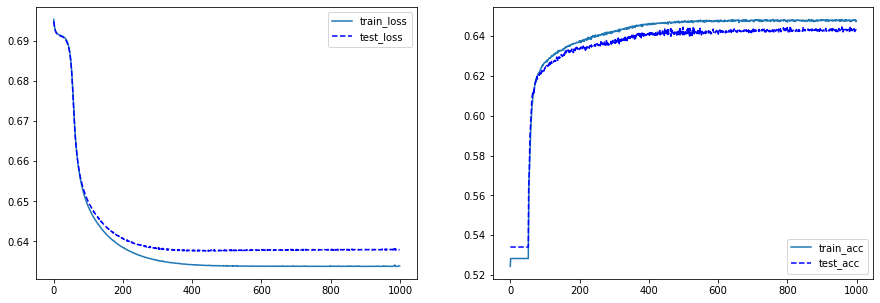

In [ ]:
graficar(historia1)

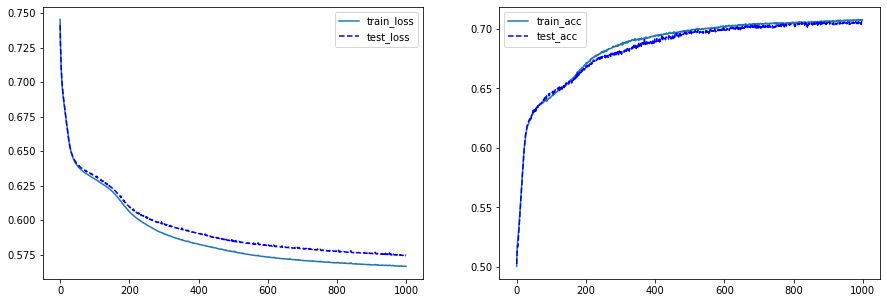

In [ ]:
graficar(historia2)

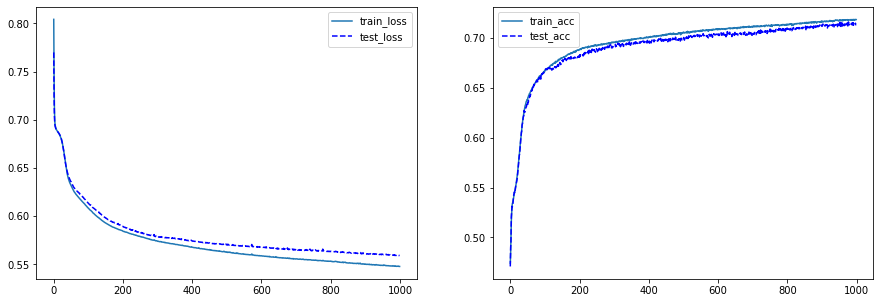

In [ ]:
graficar(historia3)

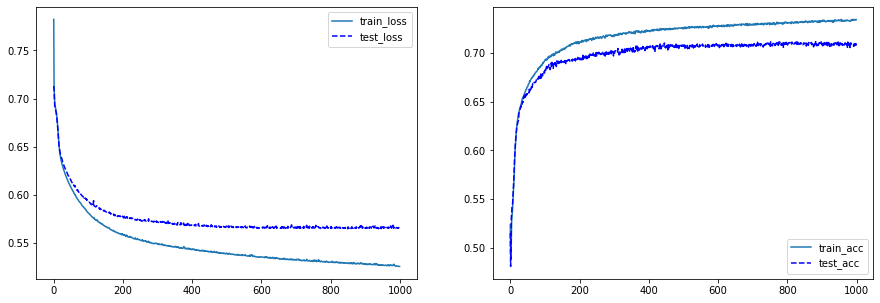

In [ ]:
graficar(historia4)

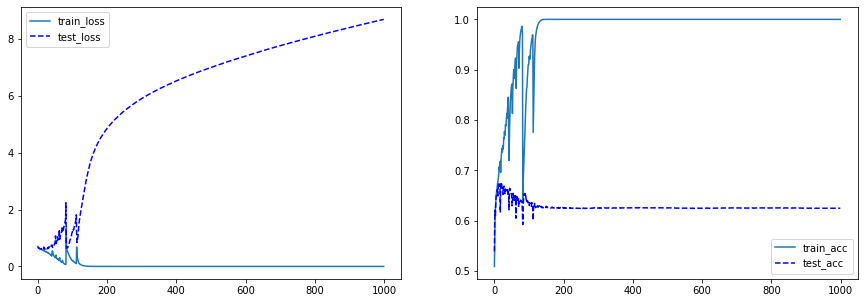

In [ ]:
graficar(historia5)

El paso a seguir sería afinar el `modelo_3`, modificando uno a uno sus hiperparámetros, entrenando, validando y verificando si hay alguna mejoría.

En lugar de esto nos enfocaremos en estrategias para reducir el *overfitting* en el `modelo_5`.

#5 - Reducción del *overfitting*

A partir del `modelo_5` crearemos dos modelos adicionales con ligeras variaciones:

- `modelo_5a`: se agregará *Drop out* al `modelo_5``
- `modelo_5b`: se agregará *weight regularization* al `modelo_5`

In [ ]:
# modelo_5a
from tensorflow.keras.layers import Dropout
modelo5a = Sequential()
modelo5a.add(Dense(512, activation='relu', input_shape=(DIM_ENTRADA,), name='capa_1'))
modelo5a.add(Dropout(0.5))
modelo5a.add(Dense(512, activation='relu', name='capa_2'))
modelo5a.add(Dropout(0.5))
modelo5a.add(Dense(512, activation='relu', name='capa_3'))
modelo5a.add(Dropout(0.5))
modelo5a.add(Dense(512, activation='relu', name='capa_4'))
modelo5a.add(Dropout(0.5))
modelo5a.add(Dense(DIM_SALIDA, activation='sigmoid', name='capa_salida'))
modelo5a._name = 'modelo_5a'
modelo5a.summary()

Model: "modelo_5a"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
capa_1 (Dense)               (None, 512)               14848     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
capa_2 (Dense)               (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
capa_3 (Dense)               (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
capa_4 (Dense)               (None, 512)               26

In [ ]:
# modelo_5b
from tensorflow.keras.regularizers import l2

modelo5b = Sequential()
modelo5b.add(Dense(512, activation='relu', input_shape=(DIM_ENTRADA,),
                   kernel_regularizer=l2(1e-3), name='capa_1'))
modelo5b.add(Dense(512, activation='relu', kernel_regularizer=l2(1e-3), name='capa_2'))
modelo5b.add(Dense(512, activation='relu', kernel_regularizer=l2(1e-3), name='capa_3'))
modelo5b.add(Dense(512, activation='relu', kernel_regularizer=l2(1e-3), name='capa_4'))
modelo5b.add(Dense(DIM_SALIDA, activation='sigmoid', name='capa_salida'))
modelo5b._name = 'modelo_5b'
modelo5b.summary()

Model: "modelo_5b"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
capa_1 (Dense)               (None, 512)               14848     
_________________________________________________________________
capa_2 (Dense)               (None, 512)               262656    
_________________________________________________________________
capa_3 (Dense)               (None, 512)               262656    
_________________________________________________________________
capa_4 (Dense)               (None, 512)               262656    
_________________________________________________________________
capa_salida (Dense)          (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Entrenamiento
historia5a = compilar_entrenar(modelo5a)
historia5b = compilar_entrenar(modelo5b)

modelo_5a - precisión entrenamiento/prueba: 91.97%/71.05%
modelo_5b - precisión entrenamiento/prueba: 90.12%/67.01%


En este punto una alternativa consiste en modificar los hiperparámetros de regularización en cada modelo, aunque en este caso particular los resultados indican que la mejor estrategia es reducir el número de capas del modelo.

#6 - Validación del modelo elegido

Finalmente, calcularemos el desempeño del `modelo_3` con el set de validación:

In [ ]:
validacion = modelo3.evaluate(x_val,y_val)

print('Precisión con el set de validación: {:.2f}%'
  .format(100*validacion[1]))

313/313 [==============================] - 1s 2ms/step - loss: 0.5624 - accuracy: 0.7084
Precisión con el set de validación: 70.84%
